In [1]:
import os

import gym
from habitat_baselines.common import env_spec
import numpy as np

import habitat
import habitat.gym
from habitat_baselines.common.env_spec import EnvironmentSpec
from habitat.utils.visualizations.utils import (
    observations_to_image,
    overlay_frame,
)
from habitat_baselines.rl.ddppo.ddp_utils import (
    EXIT,
    get_distrib_size,
    init_distrib_slurm,
    is_slurm_batch_job,
    load_resume_state,
    rank0_only,
    requeue_job,
    save_resume_state,
)
import hydra
from habitat_baselines.common.baseline_registry import baseline_registry

import torch
from habitat_baselines.utils.info_dict import extract_scalars_from_info


from habitat_baselines.common.obs_transformers import (
    apply_obs_transforms_batch,
    apply_obs_transforms_obs_space,
    get_active_obs_transforms,
)
from habitat_baselines.utils.common import (
    batch_obs,
    generate_video,
    get_action_space_info,
    inference_mode,
    is_continuous_action_space,
)

from lmnav.emb_transfer.old_eai_policy import OldEAIPolicy


# Quiet the Habitat simulator logging
os.environ["MAGNUM_LOG"] = "quiet"
os.environ["HABITAT_SIM_LOG"] = "quiet"

os.chdir('/srv/flash1/pputta7/projects/lm-nav')


[2023-09-04 09:14:21,936] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [40]:

def _init_envs(config=None, is_eval: bool = False):
    env_factory = hydra.utils.instantiate(config.habitat_baselines.vector_env_factory)
    envs = env_factory.construct_envs(
            config,
            workers_ignore_signals=is_slurm_batch_job(),
            enforce_scenes_greater_eq_environments=is_eval,
            is_first_rank=(
                not torch.distributed.is_initialized()
                or torch.distributed.get_rank() == 0
            ),
        )
    _env_spec = EnvironmentSpec(
        observation_space=envs.observation_spaces[0],
        action_space=envs.action_spaces[0],
        orig_action_space=envs.orig_action_spaces[0],
    )

    return envs, _env_spec

def _create_obs_transforms(config, env_spec):
    obs_transforms = get_active_obs_transforms(config)
    env_spec.observation_space = apply_obs_transforms_obs_space(
            env_spec.observation_space, obs_transforms
        )
    return obs_transforms, env_spec

def _setup_teacher(teacher_ckpt, obs_space, action_space):
    teacher = OldEAIPolicy.hardcoded(OldEAIPolicy, obs_space, action_space)
    torch.set_grad_enabled(False)

    ckpt_dict = torch.load(teacher_ckpt)
    state_dict = ckpt_dict['state_dict']
    state_dict = {k[len('actor_critic.'):]: v for k, v in state_dict.items()}

    teacher.load_state_dict(state_dict)
    return teacher


def _construct_state_tensors(num_environments, device):
    rnn_hx = torch.zeros((num_environments, 2, 512), device=device)
    prev_actions = torch.zeros(num_environments, 1, device=device, dtype=torch.long)
    not_done_masks = torch.ones(num_environments, 1, device=device, dtype=torch.bool)

    return rnn_hx, prev_actions, not_done_masks 
    
    
def collect_episodes(envs, teacher, obs_transform, device, deterministic=False, filter_f=None, N=None):
    if filter_f is None:
        filter_f = lambda _: True
    
    device = torch.device(device)
    num_envs = envs.num_envs
    step = 0
    dataset = []
    episodes = [[] for _ in range(num_envs)]

    rnn_hx, prev_actions, not_done_masks = _construct_state_tensors(num_envs, device)

    teacher.to(device)
    teacher.eval()
    
    observations = envs.reset()

    while (N is None) or (len(dataset) < N):
        print(step)
        # roll out a step
        batch = batch_obs(observations, device)
        batch = apply_obs_transforms_batch(batch, obs_transform)
    
        policy_result = teacher.act(batch,
                                  rnn_hx,
                                  prev_actions,
                                  not_done_masks,
                                  deterministic=deterministic)
        
        prev_actions.copy_(policy_result.actions)
        rnn_hx = policy_result.rnn_hidden_states
    
        step_data = [a.item() for a in policy_result.env_actions.cpu()]
        outputs = envs.step(step_data)
        next_observations, rewards_l, dones, infos = [list(x) for x in zip(*outputs)]
    
        # insert episode into list
        for i, episode in enumerate(episodes):
            episode.append({'observation': observations[i],
                            'reward': rewards_l[i],
                            'info': infos[i],
                            'action': step_data[i]})
    
        # check if any episodes finished and archive it into dataset
        for i, done in enumerate(dones):
            if done and filter_f(episodes[i]):
                dataset.append(episodes[i])
                episodes[i] = []
    
                # reset state tensors
                rnn_hx[i] = torch.zeros(rnn_hx.shape[1:])
                prev_actions[i] = torch.zeros(prev_actions.shape[1:])
                not_done_masks[i] = torch.ones(not_done_masks.shape[1:])
    
        observations = next_observations
        step += 1

    return dataset

In [41]:
config = habitat.get_config("lmnav/configs/habitat/imagenav_hm3d.yaml")
envs, env_spec = _init_envs(config)
obs_transform, env_spec = _create_obs_transforms(config, env_spec)

teacher_ckpt = "ckpts/uLHP.300.pth"
teacher = _setup_teacher(teacher_ckpt, env_spec.observation_space, env_spec.action_space)

2023-09-04 11:09:13,630 Initializing dataset PointNav-v1
2023-09-04 11:09:13,631 There are less scenes (1) than environments (2). Each environment will use all the scenes instead of using a subset.
2023-09-04 11:09:18,123 Initializing dataset PointNav-v1
2023-09-04 11:09:18,404 initializing sim Sim-v0
2023-09-04 11:09:20,206 Initializing task Nav-v0
2023-09-04 11:09:22,255 Initializing dataset PointNav-v1
2023-09-04 11:09:22,534 initializing sim Sim-v0
2023-09-04 11:09:23,807 Initializing task Nav-v0
2023-09-04 11:09:24,299 Resizing observation of depth: from (480, 640) to (120, 160)
2023-09-04 11:09:24,300 Resizing observation of imagegoal: from (480, 640) to (120, 160)
2023-09-04 11:09:24,301 Resizing observation of rgb: from (480, 640) to (120, 160)
2023-09-04 11:09:25,321 Using weights from /srv/flash1/rramrakhya6/summer_2022/mae-for-eai/data/visual_encoders/mae_vit_small_decoder_large_HGPS_RE10K_100.pth: _IncompatibleKeys(missing_keys=[], unexpected_keys=['mask_token', 'decoder_po

In [42]:
device = 'cuda:0'
f = lambda episodes: episodes[-1]['info']['distance_to_goal'] <= 1
dataset = collect_episodes(envs, teacher, obs_transform, device, deterministic=False, filter_f=f, N=2)
# 2 GB vram

0
1
2


/coc/testnvme/pputta7/mambaforge/envs/lmnav/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248


In [43]:
from lmnav.common.config import Config
from lmnav.common.registry import registry

from lmnav.models import *
from lmnav.processors import *
import lmnav

import os
from collections import namedtuple

import importlib
importlib.reload(lmnav.models)

<module 'lmnav.models' from '/coc/testnvme/pputta7/projects/lm-nav/lmnav/models/__init__.py'>

In [44]:
Args = namedtuple("Args", "cfg_path, model_type, gpu_id, options")
args = Args("/srv/flash1/pputta7/projects/lm-nav/exp_configs/lin_nav_llama_train.yaml", "llama_v2", 0, [])

cfg = Config(args)

model_config = cfg.model_cfg
model_cls = registry.get_model_class(model_config.arch)
model = model_cls.from_config(model_config).to('cuda')
model.eval()
#+15Gb = 17 GB vram

Loading VIT
Loading VIT Done
Loading Q-Former


Using pad_token, but it is not set yet.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LinNavLLAMA(
  (visual_encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-38): 39 x Block(
        (norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1408, out_features=4224, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1408, out_features=1408, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1408, out_features=6144, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
 

In [45]:
cfg.model_cfg

{'arch': 'lin_nav_llama', 'image_size': 224, 'drop_path_rate': 0, 'use_grad_checkpoint': False, 'vit_precision': 'fp16', 'freeze_vit': True, 'freeze_qformer': True, 'num_query_token': 32, 'llama_model': 'meta-llama/Llama-2-7b-chat-hf', 'prompt': '', 'model_type': 'pretrain_vicuna', 'max_txt_len': 512, 'end_sym': '###', 'low_resource': False, 'frozen_llama_proj': False, 'equip_audio_branch': False, 'fusion_head_layers': 2, 'max_frame_pos': 500, 'fusion_header_type': 'seqTransf'}

In [46]:
import torch
import einops

def preprocess_episode(episode):
    rgb = [torch.from_numpy(episode[0]['observation']['imagegoal'])] + [torch.from_numpy(e['observation']['rgb']) for e in episode]
    rgb = torch.stack(rgb) # (T, H, W, C)
    rgb = einops.rearrange(rgb, 't h w c -> c t h w')
    rgb = rgb.float()
    
    vis_processor_cfg = cfg.config.preprocess.vis_processor.train
    vis_processor = registry.get_processor_class(vis_processor_cfg.name).from_config(vis_processor_cfg)
    rgb = vis_processor.transform(rgb)

    goal, rgb = rgb[:, 0], rgb[:, 1:]
    return goal, rgb

def subsample_sequences(N, T, rgbs, goals):
    # todo
    samples = [rgbs[0][:, 0:T], rgbs[1][:, 0:T]]
    goals = [goals[0], goals[1]]
    return torch.stack(goals, dim=0), torch.stack(samples, dim=0)

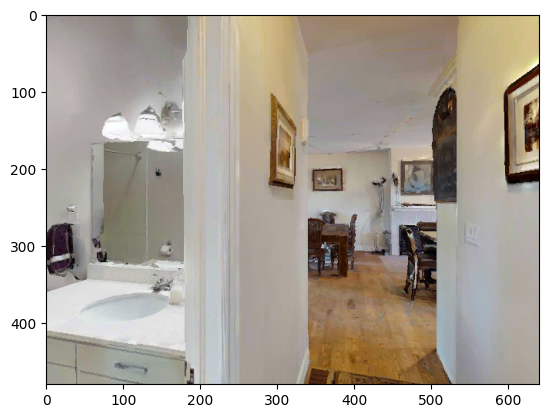

In [47]:
from matplotlib import pyplot as plt

plt.imshow(dataset[0][0]['observation']['rgb'])

In [29]:
goals, rgbs = list(zip(*[preprocess_episode(d) for d in dataset]))
print(rgbs[0].shape)
goals, rgbs = subsample_sequences(1, 20, rgbs, goals)
goals = einops.rearrange(goals, 'b c ... -> b c 1 ...')
rgb_embds, rgb_attns = model.encode_Qformer_visual(rgbs.to('cuda').half())
goal_embds, goal_attns = model.encode_Qformer_visual(goals.to('cuda').half())

goal_embds.shape, rgb_embds.shape

torch.Size([3, 74, 224, 224])


(torch.Size([2, 1, 32, 4096]), torch.Size([2, 20, 32, 4096]))

In [49]:
[torch.tensor([state['action'] for state in episode]) for episode in dataset]

[tensor([3, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 3, 1, 2, 2, 2, 2, 1, 1, 3, 3, 1, 2, 2,
         1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 3, 1, 3, 1, 2, 1, 1, 1, 3, 1, 1,
         1, 2, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 2, 0]),
 tensor([2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2,
         2, 2, 2, 2, 1, 1, 1, 3, 1, 2, 2, 2, 2, 0, 1, 3, 1, 3, 1, 3, 1, 2, 2, 2,
         2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 3, 1, 3, 1, 3, 1, 2, 2, 2, 2, 2, 2,
         2, 1, 1, 2, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1,
         1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1,
         3, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 2, 0])]

In [31]:
idx2class = {
    0: 'stop',
    1: 'forward',
    2: 'left',
    3: 'right'
}
actions = torch.randint(0, 4, (2, 20)).tolist()
actions = [[idx2class[act] for act in acts_t] for acts_t in actions]

In [32]:
prompt = "You are a navigational agent tasked with exploring an indoor environment to find a goal image. \
          You are provided with the goal image: {} and the past state action history: {}. Choose the best. \
          next action from { left, right, forward, stop }: {}"
prompt2 = "You are a navigational agent tasked with exploring an indoor environment to find a goal image. \
           You can choose to move { left, right, forward, stop } at every step. The goal image is {}. \
           After every image, choose the best action. {}"

In [33]:
B, T, Q, H = rgb_embds.shape
prompt_segs = prompt2.split("{}")
prompt_tkns = [model.llama_tokenizer(seg, return_tensors='pt', add_special_tokens=(i == 0)) for i, seg in enumerate(prompt_segs) if len(seg)]

prompt_embds = [model.llama_model.model.embed_tokens(tkns.input_ids.to('cuda')) for tkns in prompt_tkns]
prompt_embds = [embd.repeat(B, 1, 1) for embd in prompt_embds]

action_tkns = [model.llama_tokenizer(' '.join(act), return_tensors='pt', add_special_tokens=False) for act in actions]
action_tkns_t = torch.stack([tkn.input_ids.to('cuda') for tkn in action_tkns])
action_embds = [model.llama_model.model.embed_tokens(tkns.input_ids.to('cuda')) for tkns in action_tkns]
action_embds = torch.cat(action_embds, dim=0)
assert action_embds.shape[1] == T

# test to make sure actions after tokenization are the same
action_outs = model.llama_tokenizer.batch_decode(torch.cat([tkn.input_ids for tkn in action_tkns], dim=0))
action_ins = [' '.join(act) for act in actions]
actions_eq = [i == o for i, o in zip(action_ins, action_outs)]
assert all(actions_eq)

rgb_qs_embds = rgb_embds.view(B, T * Q, H)

# test to make sure flatten went as expected
for b in range(B):
    for t in range(T):
        for q in range(Q):
            assert torch.allclose(rgb_qs_embds[b, t*Q + q], rgb_embds[b, t, q])

action_embds = einops.rearrange(action_embds, 'b t h -> b t 1 h')
s_a_embds = torch.cat([rgb_embds, action_embds], dim=2)
s_a_embds = s_a_embds.view(B, T * (Q + 1), H)

goal_embds = goal_embds.squeeze(1)

embds = [prompt_embds[0], goal_embds, prompt_embds[1], s_a_embds]
embds = torch.cat(embds, dim=1)

prompt_tgts = torch.ones(B, prompt_embds[0].shape[1] + goal_embds.shape[1] + prompt_embds[1].shape[1]).fill_(-100).to('cuda')
rgb_tgts = torch.ones(B, T, Q).fill_(-100).to('cuda')
act_tgts = action_tkns_t.permute(0, 2, 1)
s_a_tgts = torch.cat([rgb_tgts, act_tgts], dim=2).view(B, T * (Q + 1))


tgts = torch.cat([prompt_tgts, s_a_tgts], dim=1).long().to('cuda')

In [34]:
embds.shape

torch.Size([2, 750, 4096])

In [35]:
embds = [prompt_embds[0], goal_embds, prompt_embds[1], s_a_embds]
embds = torch.cat(embds, dim=1)

outputs = model.llama_model(
                inputs_embeds=embds.to('cuda'),
                labels=tgts,
                return_dict=True,
            )
loss = outputs.loss

print(outputs.logits)

> /coc/testnvme/pputta7/projects/lm-nav/lmnav/models/modeling_llama.py(491)forward()
    489             raise ValueError("You cannot specify both decoder_input_ids and decoder_inputs_embeds at the same time")
    490         elif input_ids is not None:
--> 491             batch_size, seq_length = input_ids.shape
    492         elif inputs_embeds is not None:
    493             batch_size, seq_length, _ = inputs_embeds.shape



ipdb>  c


tensor([[[ 0.2334,  0.0544,  0.2695,  ...,  1.4219,  2.0000,  0.7266],
         [-4.3750, -4.5312,  3.6406,  ...,  0.5781, -4.9688,  0.7578],
         [-1.5703,  3.5469,  3.8281,  ...,  1.4844, -1.7031,  2.4219],
         ...,
         [-4.9062, -0.3105,  1.3281,  ..., -2.2969, -3.0938, -2.3438],
         [-1.6094,  2.3281,  1.3984,  ...,  0.8047,  2.4062,  1.2812],
         [-3.7500,  4.6875,  6.2500,  ..., -1.0078, -0.3105,  1.5625]],

        [[ 0.2334,  0.0544,  0.2695,  ...,  1.4219,  2.0000,  0.7266],
         [-4.3750, -4.5312,  3.6406,  ...,  0.5781, -4.9688,  0.7578],
         [-1.5703,  3.5469,  3.8281,  ...,  1.4844, -1.7031,  2.4219],
         ...,
         [-1.0781,  2.5938,  0.4922,  ...,  1.2422,  2.0312, -0.2119],
         [-2.1875,  1.9766,  2.4844,  ..., -0.2988,  1.0781,  0.8477],
         [-3.6406,  5.7812,  7.8750,  ..., -0.6445,  0.9492,  0.7305]]],
       device='cuda:0', dtype=torch.bfloat16)


In [36]:
outputs.logits.isnan().any()

tensor(False, device='cuda:0')

In [37]:
outputs.loss

tensor(11.5000, device='cuda:0', dtype=torch.bfloat16)

torch.Size([2, 749, 4096])